In [509]:
import PIL
import cv2
from matplotlib import pyplot as plt
import multiprocessing
from functools import partial
import shutil
import itertools
import collections
import os
import numpy as np
from pdb import set_trace
%matplotlib inline
from sklearn.decomposition import PCA as sklearnPCA
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib
import uuid
import pandas as pd
import networkx as nx

In [2]:
path = 'data/msan-images/'

In [3]:
stu_fn = !ls {path}/students

In [4]:
fc_fn = !ls {path}/faculty

In [5]:
img = cv2.imread(path + 'faculty/' + fc_fn[0])
print(img.shape)

(500, 500, 3)


In [6]:
img = cv2.imread(path + 'students/' + stu_fn[0])
print(img.shape)

(150, 150, 3)


Images are of different sizes in both the groups. Student image is ***150x150*** and faculty image is ***500x500***

### Visualizing the images

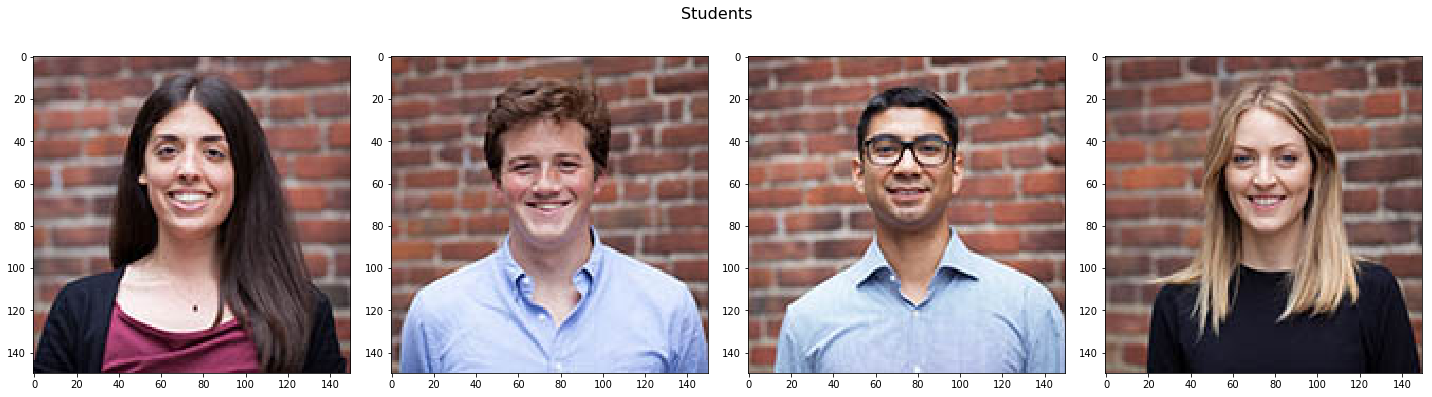

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    img = cv2.imread(path + 'students/' + stu_fn[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
plt.suptitle('Students', fontsize=16)
plt.tight_layout()

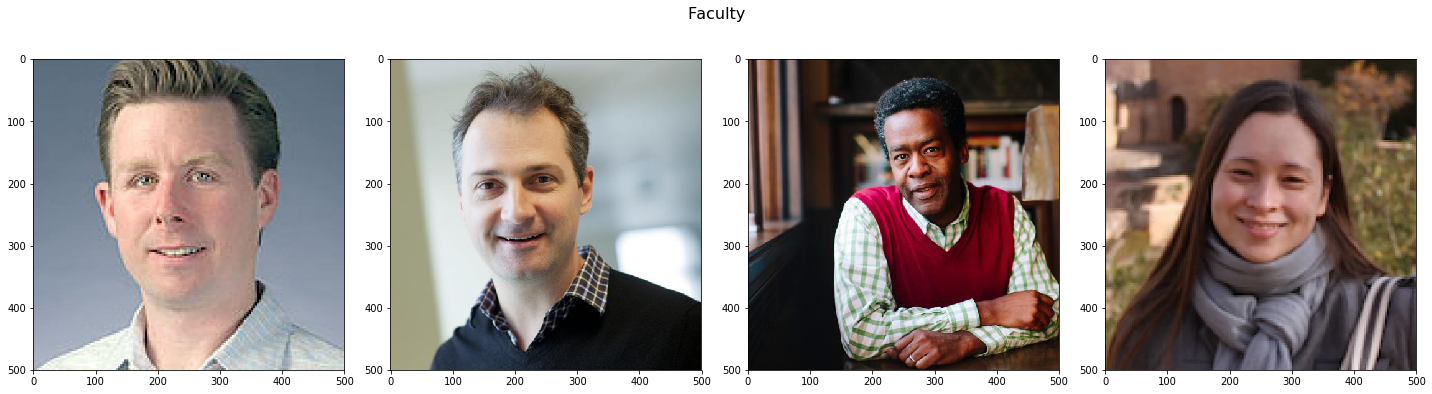

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    img = cv2.imread(path + 'faculty/' + fc_fn[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
plt.suptitle('Faculty', fontsize=16)
plt.tight_layout()

### Resizing faculty images

Resizing the faculty images to 150x150

In [9]:
# This function loads a file, resize it and write in the output folder
def img_resize(fname, outdir, sz, in_dir):
    '''
    fname: image filename
    outdir: relative path to output directory
    sz: final size of image
    in_dir: relative path to the input directory
    '''
    os.makedirs(outdir, exist_ok=True)
    im = cv2.imread(in_dir + fname)
    small_im = cv2.resize(im, (sz, sz))
    cv2.imwrite(outdir + fname, small_im)


def parallel_runs(data_list, outdir, in_dir, sz=300, process=4):
    '''
    data_list: list of filenames of images stores in a list
    outdir: relative path to output directory
    sz: final size of image
    in_dir: relative path to the input directory
    process: num of threads in your cpu
    '''
    pool = multiprocessing.Pool(processes=process)
    img_resize_x = partial(img_resize, outdir=outdir, sz=sz, in_dir=in_dir)
    pool.map(img_resize_x, data_list)
# inputdir = 'data/msan-images/faculty/'

# filelist = !ls {inputdir}

# outdir = 'data/msan-images/faculty-resized/'

# parallel_runs(filelist,outdir,inputdir,150,4)

Visualizing after resizing images

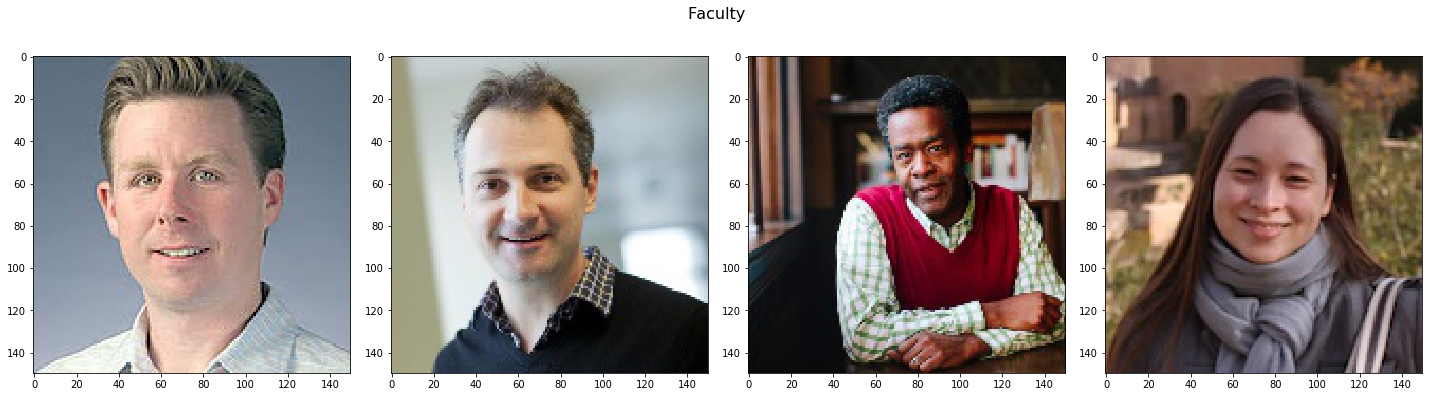

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
for i in range(4):
    img = cv2.imread(path + 'faculty-resized/' + fc_fn[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
plt.suptitle('Faculty', fontsize=16)
plt.tight_layout()

## Student Version

### Cropping faces from the image

Source: http://gregblogs.com/computer-vision-cropping-faces-from-images-using-opencv2/

In [55]:
def facechop(input_dir, fnames, output_dir):
    '''
    Extract faces from the images present in the input directory and save the cropped images in the output directory
    input:
    input_dir: path to the directory where the input images are present
    fnames: list of filenames in the input_dir for which face extraction needs to be done
    output_dir: path to the directory where the output images need to be saved
    
    return: None
    Note: 
    Output may or may not be of the same size
    There can be multiple version of cropped image. Pick the best crop
    '''
    os.makedirs(output_dir, exist_ok=True)

    facedata = "haarcascade_frontalface_default.xml"

    for fn in fnames:
        cascade = cv2.CascadeClassifier(facedata)
        img = cv2.imread(input_dir + fn)
        face = cascade.detectMultiScale(img)
        faces = []
        for i, f in enumerate(face):
            x, y, w, h = f
            sub_face = img[y:y + h, x:x + w]
            cv2.imwrite(output_dir + str(i) + "_" + fn, sub_face)
    return None

In [56]:
#extracting face from the whole image
facechop('data/msan-images/students/',stu_fn,'data/msan-images/students-faces/')

As the output of the above function has variable image size, we need to resize them to a consistent size for PCA

In [59]:
# done

sz = 50

inputdir = 'data/msan-images/students-faces/'

filelist = !ls {inputdir}

outdir = 'data/msan-images/students-faces-resized/'

parallel_runs(filelist,outdir,inputdir,sz,4)

### Eigen faces

**Step1**: Prepare a training set of face images. The pictures constituting the training set should have been taken under the same lighting conditions, and must be normalized to have the eyes and mouths aligned across all images. They must also be all resampled to a common pixel resolution (r × c). Each image is treated as one vector, simply by concatenating the rows of pixels in the original image, resulting in a single column with r × c elements. For this implementation, it is assumed that all images of the training set are stored in a single matrix T, where each column of the matrix is an image.

In [60]:
def readImages(path, fnames):
    images = []
    for f in fnames:
        imagePath = os.path.join(path, f)
        img = cv2.imread(imagePath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    numImages = len(images)
    return images

In [62]:
# Directory containing face images
dirName = "data/msan-images/students-faces-resized/"

stu_fn1 = !ls {path}/students-faces-resized/
# Read images
images = readImages(dirName, stu_fn1)

In [91]:
len(images) #75 students

75

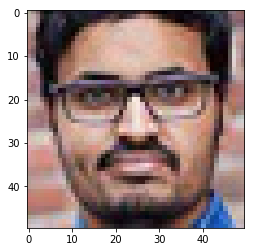

In [98]:
plt.imshow(images[40])

In [93]:
images_gray = [
    np.stack(
        (cv2.cvtColor(i, cv2.COLOR_RGB2GRAY),
         cv2.cvtColor(i, cv2.COLOR_RGB2GRAY),
         cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)),
        axis=-1) for i in images
]

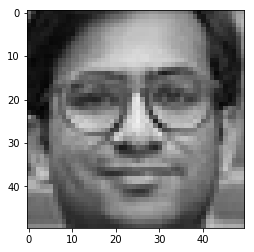

In [99]:
plt.imshow(images_gray[50])

In [100]:
def createDataMatrix(images):
    numImages = len(images)
    sz = images[0].shape
    data = np.zeros((numImages, sz[0] * sz[1] * sz[2]), dtype=np.float32)
    for i in range(0, numImages):
        image = images[i].flatten()
        data[i, :] = image
    print("DONE")
    return data

In [101]:
# Create data matrix for PCA.
data_color = createDataMatrix(images)

DONE


In [102]:
data_gray = createDataMatrix(images_gray)

DONE


In [106]:
data_color = data_color.T

In [107]:
data_gray = data_gray.T

**Step 2** : Subtract the mean. The average image a has to be calculated and then subtracted from each original image in T.

In [112]:
avg_col_img = np.mean(data_color, axis=1)

In [113]:
avg_gray_img = np.mean(data_gray,axis=1)

In [119]:
data_col_norm = (data_color - avg_col_img.reshape(7500,1))

In [120]:
data_gray_norm = (data_gray - avg_gray_img.reshape(7500,1))

In [132]:
avg_col_img = avg_col_img.reshape(50,50,3)

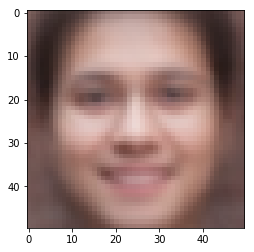

In [137]:
plt.imshow(avg_col_img/255)

In [138]:
avg_gray_img = avg_gray_img.reshape(50,50,3)

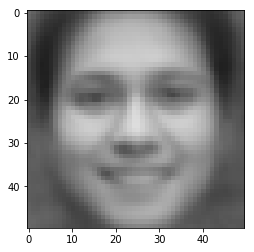

In [139]:
plt.imshow(avg_gray_img/255)

**Step 3** : Calculate the eigenvectors and eigenvalues of the covariance matrix S. Each eigenvector has the same dimensionality (number of components) as the original images, and thus can itself be seen as an image. The eigenvectors of this covariance matrix are therefore called eigenfaces. They are the directions in which the images differ from the mean image. Usually this will be a computationally expensive step (if at all possible), but the practical applicability of eigenfaces stems from the possibility to compute the eigenvectors of S efficiently, without ever computing S explicitly, as detailed below.

In [170]:
pca_col = sklearnPCA()

eigenFaces_col = pca_col.fit_transform(data_col_norm)

eigenValues_col = pca_col.explained_variance_ratio_

In [171]:
eigenFaces_col.shape

(7500, 75)

In [172]:
pca_gray = sklearnPCA()

eigenFaces_gray = pca_gray.fit_transform(data_gray_norm)

eigenFaces_gray.shape

(7500, 75)

In [173]:
eigenFaces_col

array([[-4.6639061e+01,  1.1322618e+02, -1.3388361e+02, ...,
        -2.5750309e+01, -2.7047356e+01,  7.1052644e-05],
       [-5.7653076e+01,  6.7021271e+01, -1.3393620e+02, ...,
        -5.9233165e+00,  9.5470200e+00, -4.5069704e-05],
       [-6.8965881e+01,  6.1247742e+01, -1.1963669e+02, ...,
         2.5118980e+00,  4.9608669e+00, -4.3999698e-05],
       ...,
       [ 3.1079239e+02, -6.9352631e+01, -9.3547874e+01, ...,
         4.9362755e+00,  1.6312231e+01, -2.1339418e-05],
       [ 2.6729019e+02, -2.9423210e+01, -1.0142184e+02, ...,
        -2.8282235e+00,  9.3957911e+00, -2.7094798e-05],
       [ 2.5906686e+02, -2.5780169e+01, -1.0224380e+02, ...,
        -8.4873476e+00,  1.0310207e+01,  2.1506378e-06]], dtype=float32)

In [174]:
eigenFaces_col

array([[-4.6639061e+01,  1.1322618e+02, -1.3388361e+02, ...,
        -2.5750309e+01, -2.7047356e+01,  7.1052644e-05],
       [-5.7653076e+01,  6.7021271e+01, -1.3393620e+02, ...,
        -5.9233165e+00,  9.5470200e+00, -4.5069704e-05],
       [-6.8965881e+01,  6.1247742e+01, -1.1963669e+02, ...,
         2.5118980e+00,  4.9608669e+00, -4.3999698e-05],
       ...,
       [ 3.1079239e+02, -6.9352631e+01, -9.3547874e+01, ...,
         4.9362755e+00,  1.6312231e+01, -2.1339418e-05],
       [ 2.6729019e+02, -2.9423210e+01, -1.0142184e+02, ...,
        -2.8282235e+00,  9.3957911e+00, -2.7094798e-05],
       [ 2.5906686e+02, -2.5780169e+01, -1.0224380e+02, ...,
        -8.4873476e+00,  1.0310207e+01,  2.1506378e-06]], dtype=float32)

In [195]:
def imgNorm(img):
    '''
    input: 
    img: image matrix
    return: img matrix normalized between [0,1] 
    '''
    cmin = img.min()
    cmax = img.max()
    return (img - cmin) / (cmax - cmin)

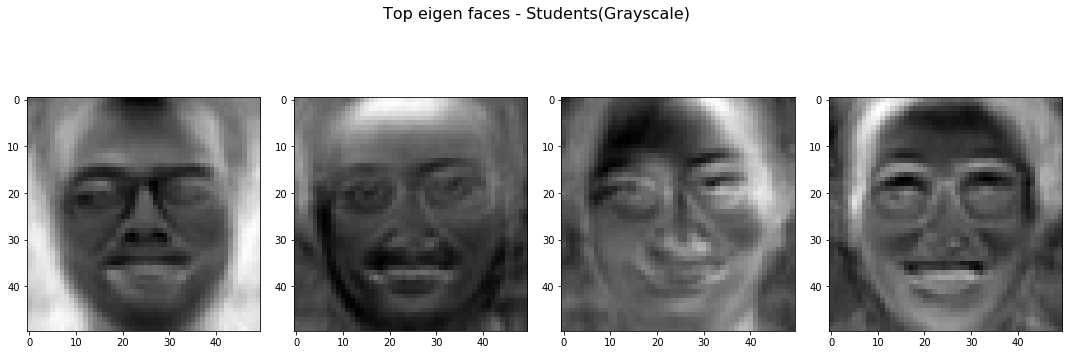

In [202]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))
for i in range(4):
    axes[i].imshow(imgNorm(eigenFaces_gray[:, i].reshape(50, 50, 3)))
plt.suptitle('Top eigen faces - Students(Grayscale)', fontsize=16)
plt.tight_layout()

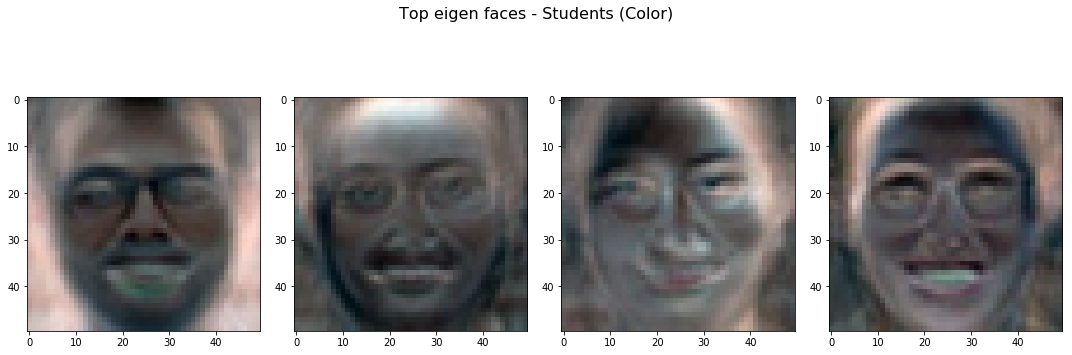

In [353]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))
for i in range(4):
    axes[i].imshow(imgNorm(eigenFaces_col[:, i].reshape(50, 50, 3)))
plt.suptitle('Top eigen faces - Students (Color)', fontsize=16)
plt.tight_layout()

**Explained variance**

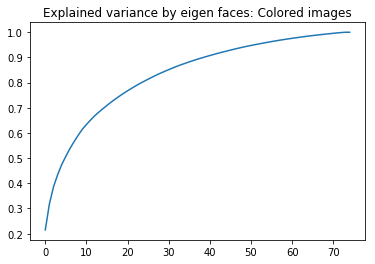

In [208]:
plt.plot(np.cumsum(pca_col.explained_variance_ratio_))
plt.title('Explained variance by eigen faces: Colored images')
plt.show()

In [217]:
print("The first 4 eigen faces explains ",
      str(np.sum(pca_col.explained_variance_ratio_[:4])),
      " of the total variability")

The first 4 eigen faces explains  0.43391624  of the total variability


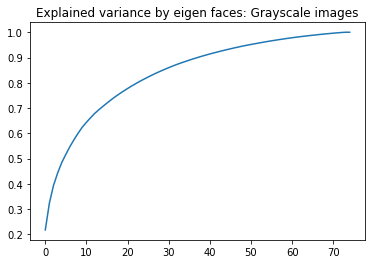

In [215]:
plt.plot(np.cumsum(pca_gray.explained_variance_ratio_))
plt.title('Explained variance by eigen faces: Grayscale images')
plt.show()

In [218]:
print("The first 4 eigen faces explains ",
      str(np.sum(pca_gray.explained_variance_ratio_[:4])),
      " of the total variability")

The first 4 eigen faces explains  0.44270492  of the total variability


**Reconstruction**

In [363]:
myImg = "data/msan-images/students-faces-resized/0_msan-student-gupta-shikhar.jpg"

In [364]:
img = cv2.imread(myImg)

In [365]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

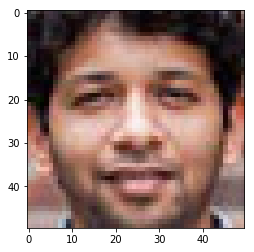

In [366]:
plt.imshow(img)

In [367]:
img_mean_norm = (img.flatten() - avg_col_img.flatten()).reshape(50, 50, 3)

In [368]:
def eigfacesCombination(eigenfaces, targetImg):
    """
    Solve for Ax = b with OLS
    eigenfaces: eigen faces matrix
    targetImg: Image to reconstruct
    w: weights
    """
    w = np.linalg.lstsq(eigenfaces, targetImg.flatten(), rcond=None)[0]
    return w

In [369]:
weights = eigfacesCombination(eigenFaces_col, img_mean_norm)

In [372]:
def imgReconstruct(eigenFaces, weights, numFaces):
    reconstruct = np.zeros((50, 50, 3))
    for i in range(numFaces):
        reconstruct += (eigenFaces[:, i] * weights[i]).reshape(50, 50, 3)
    return reconstruct

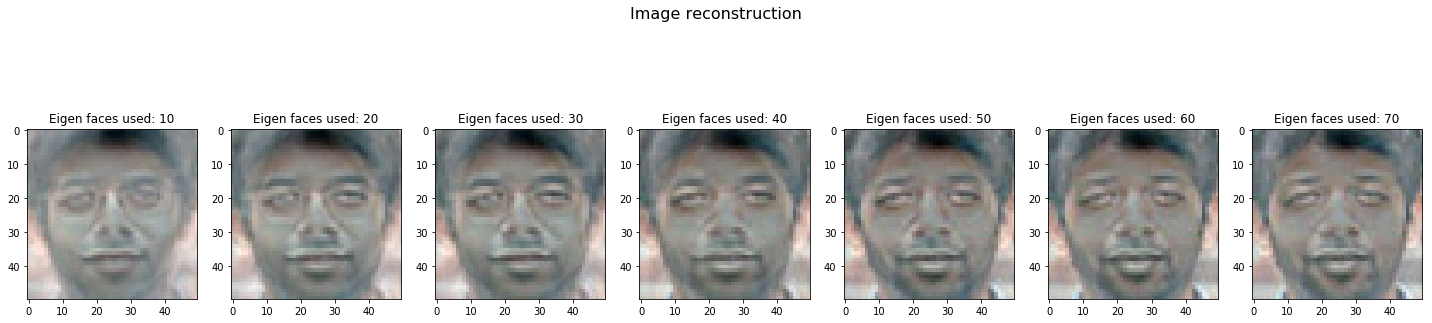

In [405]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20, 6))
for i in range(7):
    axes[i].imshow(
        imgNorm(imgReconstruct(eigenFaces_col, weights, 10 * (i + 1))))
    axes[i].set_title(f"Eigen faces used: {10 * (i + 1)}")
plt.suptitle('Image reconstruction', fontsize=16)
plt.tight_layout()

## Faculty version

### Face alignment

Source: https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/

In [411]:
shape_predictor_path = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor and the face aligner
fa = FaceAligner(predictor, desiredFaceWidth=50)
os.makedirs("data/msan-images/faculty-faces_aligned/", exist_ok=True)
for fn in fc_fn:
    image_path = f"data/msan-images/faculty-resized/{fn}"
    # load the input image, resize it, and convert it to grayscale
    image = cv2.imread(image_path)
    #     image = imutils.resize(image, width=800)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 2)
    # loop over the face detections
    for i, rect in enumerate(rects):
        # extract the ROI of the *original* face, then align the face
        # using facial landmarks
        (x, y, w, h) = rect_to_bb(rect)
        faceOrig = imutils.resize(image[y:y + h, x:x + w], width=50)
        faceAligned = fa.align(image, gray, rect)
        cv2.imwrite(
            "data/msan-images/faculty-faces_aligned/" + str(i) + "_" + fn,
            faceAligned)

### Eigen faces

In [412]:
# Directory containing face images
dirName = "data/msan-images/faculty-faces_aligned/"

fc_fn = !ls {path}/faculty-faces_aligned/
# Read images
images = readImages(dirName, fc_fn)

In [413]:
len(images) #75 students

15

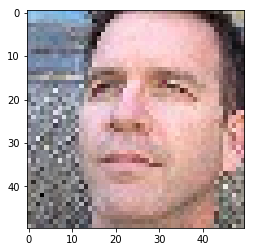

In [414]:
plt.imshow(images[9])

In [415]:
images_gray = [
    np.stack(
        (cv2.cvtColor(i, cv2.COLOR_RGB2GRAY),
         cv2.cvtColor(i, cv2.COLOR_RGB2GRAY),
         cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)),
        axis=-1) for i in images
]

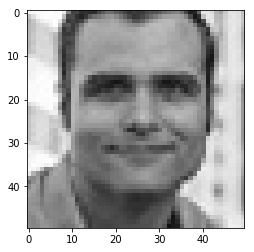

In [416]:
plt.imshow(images_gray[8])

In [419]:
# Create data matrix for PCA.
data_color = createDataMatrix(images)

DONE


In [420]:
data_gray = createDataMatrix(images_gray)

DONE


In [421]:
data_color = data_color.T

In [422]:
data_gray = data_gray.T

**Step 2** : Subtract the mean. The average image a has to be calculated and then subtracted from each original image in T.

In [423]:
avg_col_img = np.mean(data_color, axis=1)

In [424]:
avg_gray_img = np.mean(data_gray,axis=1)

In [425]:
data_col_norm = (data_color - avg_col_img.reshape(7500,1))

In [426]:
data_gray_norm = (data_gray - avg_gray_img.reshape(7500,1))

In [427]:
avg_col_img = avg_col_img.reshape(50,50,3)

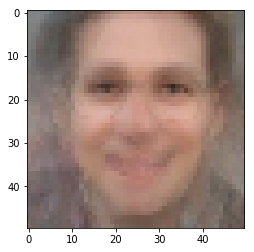

In [428]:
plt.imshow(avg_col_img/255)

In [429]:
avg_gray_img = avg_gray_img.reshape(50,50,3)

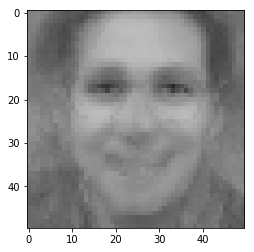

In [430]:
plt.imshow(avg_gray_img/255)

**Step 3** : Calculate the eigenvectors and eigenvalues of the covariance matrix S. Each eigenvector has the same dimensionality (number of components) as the original images, and thus can itself be seen as an image. The eigenvectors of this covariance matrix are therefore called eigenfaces. They are the directions in which the images differ from the mean image. Usually this will be a computationally expensive step (if at all possible), but the practical applicability of eigenfaces stems from the possibility to compute the eigenvectors of S efficiently, without ever computing S explicitly, as detailed below.

In [431]:
pca_col = sklearnPCA()

eigenFaces_col = pca_col.fit_transform(data_col_norm)

eigenValues_col = pca_col.explained_variance_ratio_

In [432]:
eigenFaces_col.shape

(7500, 15)

In [433]:
pca_gray = sklearnPCA()

eigenFaces_gray = pca_gray.fit_transform(data_gray_norm)

eigenFaces_gray.shape

(7500, 15)

In [434]:
eigenFaces_col

array([[ 4.0070286e+00, -1.6881023e+02, -3.3376217e+01, ...,
         3.9667820e+01, -2.3272694e+01,  7.6493179e-06],
       [-1.8771772e+01, -1.6431262e+02, -6.5649857e+01, ...,
        -9.9718084e+00,  6.3570395e+00,  4.3004264e-05],
       [-5.0521076e+01, -1.4702306e+02, -8.3073784e+01, ...,
        -4.3117138e+01,  2.4456770e+01, -3.4617071e-05],
       ...,
       [-9.6008858e+01, -1.2420379e+02,  1.6952837e+02, ...,
        -2.2940823e+01,  7.2587563e+01,  5.6886047e-06],
       [-7.6139923e+01, -1.2962404e+02,  1.5057465e+02, ...,
        -2.7906748e+01,  7.0601631e+01,  7.9642859e-06],
       [-7.6770203e+01, -1.2911453e+02,  1.3865634e+02, ...,
        -4.2431049e+01,  5.0729366e+01, -3.6173174e-06]], dtype=float32)

In [435]:
eigenFaces_col

array([[ 4.0070286e+00, -1.6881023e+02, -3.3376217e+01, ...,
         3.9667820e+01, -2.3272694e+01,  7.6493179e-06],
       [-1.8771772e+01, -1.6431262e+02, -6.5649857e+01, ...,
        -9.9718084e+00,  6.3570395e+00,  4.3004264e-05],
       [-5.0521076e+01, -1.4702306e+02, -8.3073784e+01, ...,
        -4.3117138e+01,  2.4456770e+01, -3.4617071e-05],
       ...,
       [-9.6008858e+01, -1.2420379e+02,  1.6952837e+02, ...,
        -2.2940823e+01,  7.2587563e+01,  5.6886047e-06],
       [-7.6139923e+01, -1.2962404e+02,  1.5057465e+02, ...,
        -2.7906748e+01,  7.0601631e+01,  7.9642859e-06],
       [-7.6770203e+01, -1.2911453e+02,  1.3865634e+02, ...,
        -4.2431049e+01,  5.0729366e+01, -3.6173174e-06]], dtype=float32)

In [436]:
def imgNorm(img):
    '''
    input: 
    img: image matrix
    return: img matrix normalized between [0,1] 
    '''
    cmin = img.min()
    cmax = img.max()
    return (img - cmin) / (cmax - cmin)

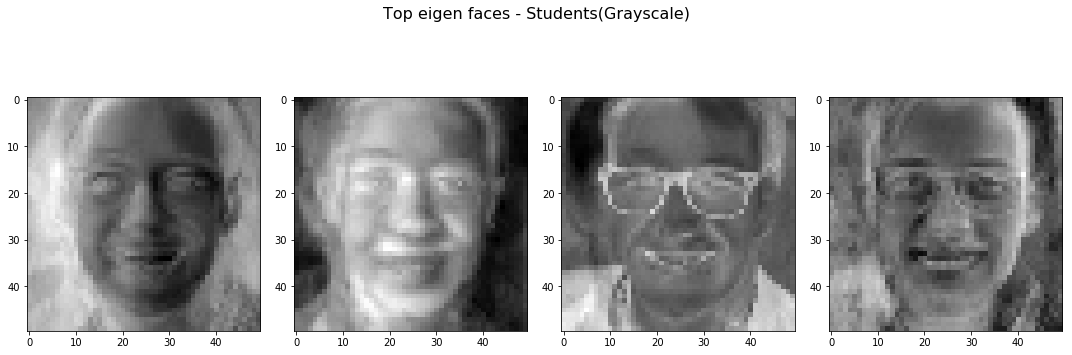

In [437]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))
for i in range(4):
    axes[i].imshow(imgNorm(eigenFaces_gray[:, i].reshape(50, 50, 3)))
plt.suptitle('Top eigen faces - Faculty(Grayscale)', fontsize=16)
plt.tight_layout()

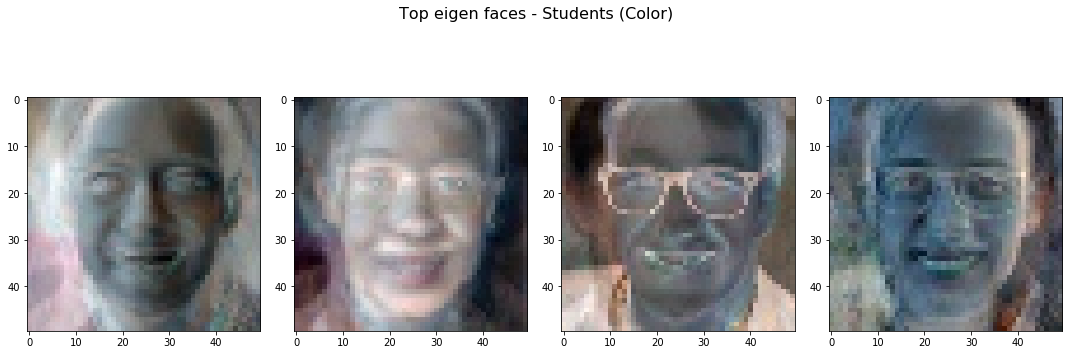

In [438]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))
for i in range(4):
    axes[i].imshow(imgNorm(eigenFaces_col[:, i].reshape(50, 50, 3)))
plt.suptitle('Top eigen faces - Faculty (Color)', fontsize=16)
plt.tight_layout()

**Explained variance**

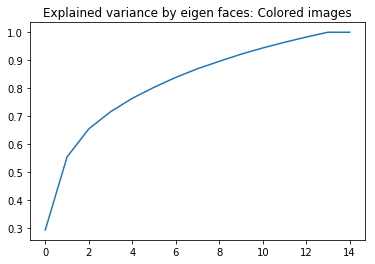

In [439]:
plt.plot(np.cumsum(pca_col.explained_variance_ratio_))
plt.title('Explained variance by eigen faces: Colored images')
plt.show()

In [440]:
print("The first 4 eigen faces explains ",
      str(np.sum(pca_col.explained_variance_ratio_[:4])),
      " of the total variability")

The first 4 eigen faces explains  0.7151921  of the total variability


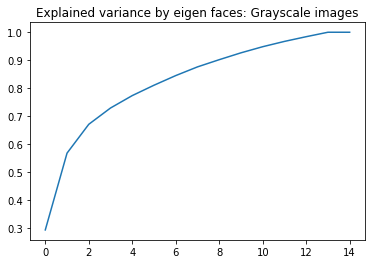

In [441]:
plt.plot(np.cumsum(pca_gray.explained_variance_ratio_))
plt.title('Explained variance by eigen faces: Grayscale images')
plt.show()

In [442]:
print("The first 4 eigen faces explains ",
      str(np.sum(pca_gray.explained_variance_ratio_[:4])),
      " of the total variability")

The first 4 eigen faces explains  0.7293472  of the total variability


**Reconstruction**

In [443]:
myImg = "data/msan-images/faculty-faces_aligned/0_wilson-james.jpg"

In [444]:
img = cv2.imread(myImg)

In [445]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

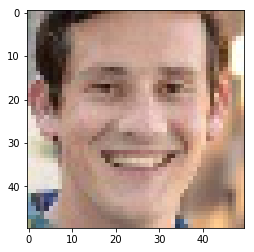

In [446]:
plt.imshow(img)

In [447]:
img_mean_norm = (img.flatten() - avg_col_img.flatten()).reshape(50, 50, 3)

In [449]:
weights = eigfacesCombination(eigenFaces_col, img_mean_norm)

In [453]:
len(weights)

15

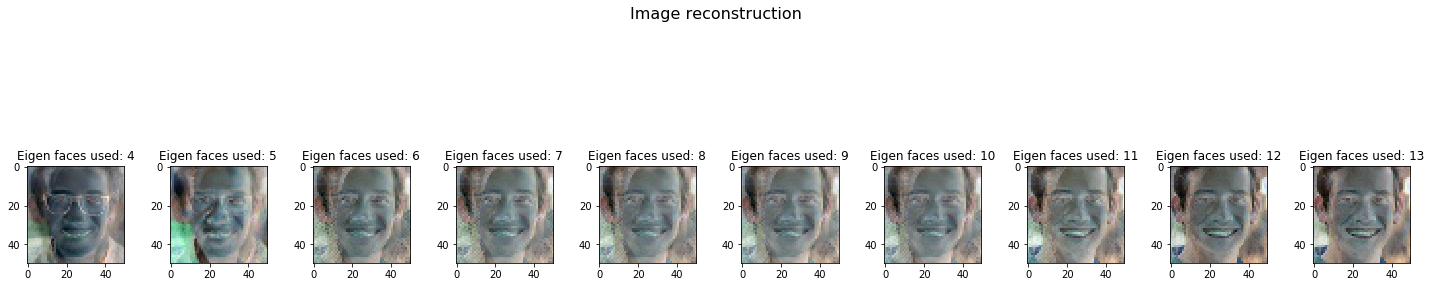

In [457]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 6))
for i in range(10):
    axes[i].imshow(imgNorm(imgReconstruct(eigenFaces_col, weights, i + 4)))
    axes[i].set_title(f"Eigen faces used: {i+4}")
plt.suptitle('Image reconstruction', fontsize=16)
plt.tight_layout()

In [458]:
myImg = "data/msan-images/faculty-faces_aligned/0_parr_terrence.jpg"

In [459]:
img = cv2.imread(myImg)

In [460]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

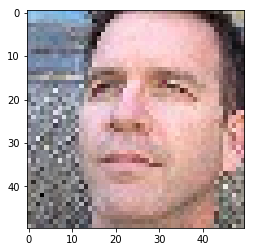

In [461]:
plt.imshow(img)

In [462]:
img_mean_norm = (img.flatten() - avg_col_img.flatten()).reshape(50, 50, 3)

In [464]:
weights = eigfacesCombination(eigenFaces_col, img_mean_norm)

In [465]:
len(weights)

15

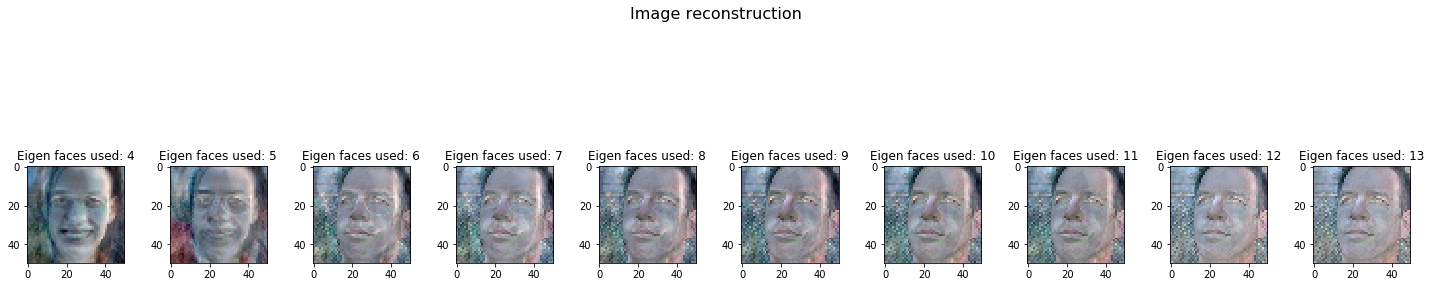

In [467]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 6))
for i in range(10):
    axes[i].imshow(imgNorm(imgReconstruct(eigenFaces_col, weights, i + 4)))
    axes[i].set_title(f"Eigen faces used: {i+4}")
plt.suptitle('Image reconstruction', fontsize=16)
plt.tight_layout()

In [468]:
myImg = "data/msan-images/faculty-faces_aligned/0_woodbridge-diane-03.jpg"

In [469]:
img = cv2.imread(myImg)

In [470]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

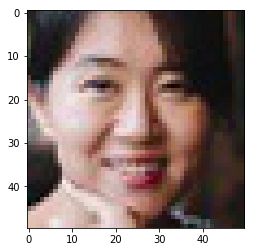

In [471]:
plt.imshow(img)

In [472]:
img_mean_norm = (img.flatten() - avg_col_img.flatten()).reshape(50, 50, 3)

In [474]:
weights = eigfacesCombination(eigenFaces_col, img_mean_norm)

In [475]:
len(weights)

15

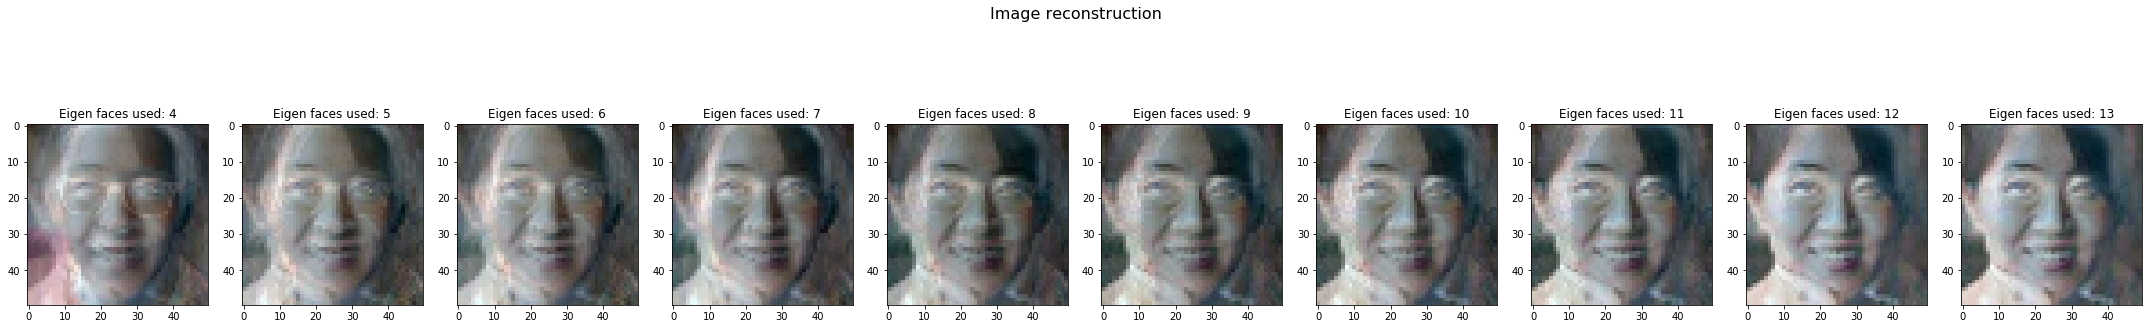

In [479]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(30, 6))
for i in range(10):
    axes[i].imshow(imgNorm(imgReconstruct(eigenFaces_col, weights, i + 4)))
    axes[i].set_title(f"Eigen faces used: {i+4}")
plt.suptitle('Image reconstruction', fontsize=16)
plt.tight_layout()

## Similarity network

### Eigen faces

In [480]:
# Directory containing face images
dirName = "data/msan-images/students-faces-resized/"

stu_fn1 = !ls {path}/students-faces-resized/
# Read images
images = readImages(dirName, stu_fn1)

In [481]:
images_gray = [
    np.stack(
        (cv2.cvtColor(i, cv2.COLOR_RGB2GRAY),
         cv2.cvtColor(i, cv2.COLOR_RGB2GRAY),
         cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)),
        axis=-1) for i in images
]

In [482]:
data_gray = createDataMatrix(images_gray)

DONE


In [483]:
data_gray = data_gray.T

In [484]:
avg_gray_img = np.mean(data_gray,axis=1)

In [485]:
data_gray_norm = (data_gray - avg_gray_img.reshape(7500,1))

In [486]:
avg_gray_img = avg_gray_img.reshape(50,50,3)

In [489]:
pca_gray = sklearnPCA()

eigenFaces_gray = pca_gray.fit_transform(data_gray_norm)

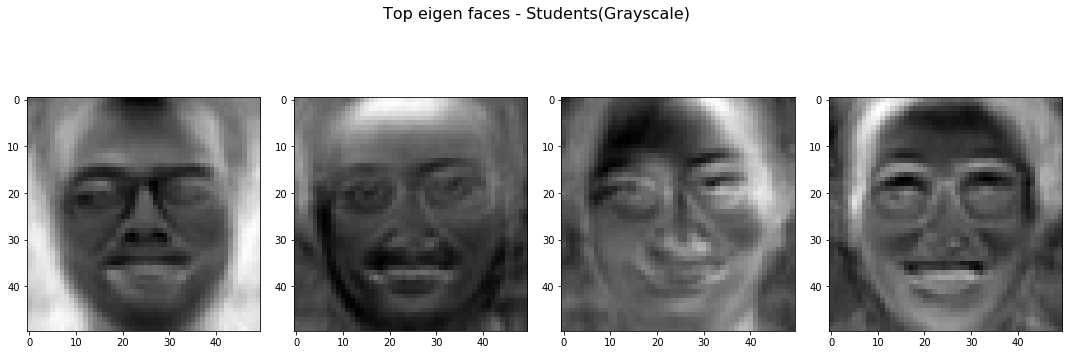

In [490]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))
for i in range(4):
    axes[i].imshow(imgNorm(eigenFaces_gray[:, i].reshape(50, 50, 3)))
plt.suptitle('Top eigen faces - Students(Grayscale)', fontsize=16)
plt.tight_layout()

**Representation in terms of eigenfaces**

In [498]:
students = ['-'.join(i.split('-')[-2:]) for i in stu_fn1]

In [501]:
students = [s.replace(".jpg","") for s in students]

In [601]:
student_dict = {}
num_eigfaces = 10
for i,s in enumerate(stu_fn1):
    myImg = f"data/msan-images/students-faces-resized/{s}"

    img = cv2.imread(myImg)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_mean_norm = (img.flatten() - avg_gray_img.flatten()).reshape(50, 50, 3)

    weights = eigfacesCombination(eigenFaces_gray, img_mean_norm)
    
    student_dict[students[i]] = imgReconstruct(eigenFaces_gray, weights, num_eigfaces).flatten()

In [602]:
df_student = pd.DataFrame.from_dict(student_dict)

In [603]:
df_student.head()

avgerinou-danai  bowers-devin  campa-ryan  capell-holly  carpenter-jason  \
0        47.939996    -14.537385   19.873133     49.487999       -15.778612   
1        47.940223    -14.537539   19.873056     49.487894       -15.778718   
2        47.940182    -14.537497   19.873152     49.487814       -15.778704   
3        37.984023    -21.579787   22.503857     63.377776       -26.550327   
4        37.984033    -21.579649   22.503874     63.377330       -26.550334   

    chen-liz   chen-si  csiszar-chris  devesh-02  dong-chris      ...        \
0  42.807234  0.426239      -4.582842  25.817368   39.369566      ...         
1  42.807384  0.426482      -4.582982  25.817359   39.369666      ...         
2  42.807260  0.426523      -4.583050  25.817306   39.369690      ...         
3  44.802734 -6.913418      11.897942  24.045189   33.418418      ...         
4  44.802672 -6.913294      11.897648  24.045302   33.418581      ...         

   wang-jingjue  white-tyler  xu-chengcheng   xu-chuan  xu-zhengjie  \
0     24.682432   -17.258039     -34.284375 -18.464226   -41.212743   
1     24.682601   -17.258166     -34.284453 -18.464196   -41.212863   
2     24.682534   -17.258118     -34.284381 -18.464159   -41.212738   
3     27.942486   -21.718507     -42.468739 -27.779818   -45.852959   
4     27.942351   -21.718374     -42.468642 -27.779741   -45.852780   

   yan-dixin  yang-patrick    yue-lan  zhao-yiqiang  zheng-vanessa  
0  29.256559    -22.293778  -6.751759    -30.490593     -14.196584  
1  29.256703    -22.293641  -6.751468    -30.490703     -14.196446  
2  29.256681    -22.293671  -6.751502    -30.490571     -14.196425  
3  28.379647    -37.297010 -28.183668    -38.472614     -16.186535  
4  28.379637    -37.296959 -28.183363    -38.472442     -16.186473  

[5 rows x 75 columns]

In [604]:
corr = df_student.corr()

In [605]:
corr.head()

avgerinou-danai  bowers-devin  campa-ryan  capell-holly  \
avgerinou-danai         1.000000     -0.268537   -0.289411      0.110837   
bowers-devin           -0.268537      1.000000    0.351818     -0.219261   
campa-ryan             -0.289411      0.351818    1.000000     -0.011462   
capell-holly            0.110837     -0.219261   -0.011462      1.000000   
carpenter-jason        -0.160048      0.476228    0.271399     -0.189452   

                 carpenter-jason  chen-liz   chen-si  csiszar-chris  \
avgerinou-danai        -0.160048  0.554178  0.658894      -0.813933   
bowers-devin            0.476228 -0.666781 -0.188086      -0.150922   
campa-ryan              0.271399 -0.325911 -0.434173       0.248345   
capell-holly           -0.189452  0.215112 -0.329887       0.314470   
carpenter-jason         1.000000 -0.414395  0.080282      -0.025059   

                 devesh-02  dong-chris      ...        wang-jingjue  \
avgerinou-danai  -0.179260    0.386617      ...            0.492214   
bowers-devin      0.534557    0.047286      ...           -0.639739   
campa-ryan        0.713675    0.526525      ...           -0.546389   
capell-holly     -0.204846   -0.156060      ...            0.130262   
carpenter-jason   0.314198   -0.237157      ...           -0.027193   

                 white-tyler  xu-chengcheng  xu-chuan  xu-zhengjie  yan-dixin  \
avgerinou-danai    -0.276931      -0.541890  0.326041    -0.449349   0.737389   
bowers-devin        0.880161       0.109348 -0.427461     0.115123  -0.571613   
campa-ryan          0.092326      -0.068780 -0.022069     0.216590  -0.532944   
capell-holly       -0.319278      -0.155741 -0.052372    -0.282744   0.133843   
carpenter-jason     0.467589      -0.345940 -0.167243    -0.099937  -0.212348   

                 yang-patrick   yue-lan  zhao-yiqiang  zheng-vanessa  
avgerinou-danai      0.446118  0.698556     -0.471038       0.469471  
bowers-devin        -0.093288 -0.339171      0.393050      -0.635150  
campa-ryan          -0.581225 -0.487293      0.405612      -0.496688  
capell-holly        -0.011106 -0.465985     -0.209916      -0.098957  
carpenter-jason     -0.449225  0.032645     -0.246261      -0.074626  

[5 rows x 75 columns]

In [606]:
links = corr.stack().reset_index()

In [607]:
links.columns = ['student1', 'student2','correlation']

In [608]:
links.head()

student1         student2  correlation
0  avgerinou-danai  avgerinou-danai     1.000000
1  avgerinou-danai     bowers-devin    -0.268537
2  avgerinou-danai       campa-ryan    -0.289411
3  avgerinou-danai     capell-holly     0.110837
4  avgerinou-danai  carpenter-jason    -0.160048

In [615]:
links_filtered=links.loc[ (links['correlation'] > 0.8) & (links['student1'] != links['student2']) ]

In [617]:
G=nx.from_pandas_edgelist(links_filtered, 'student1', 'student2')

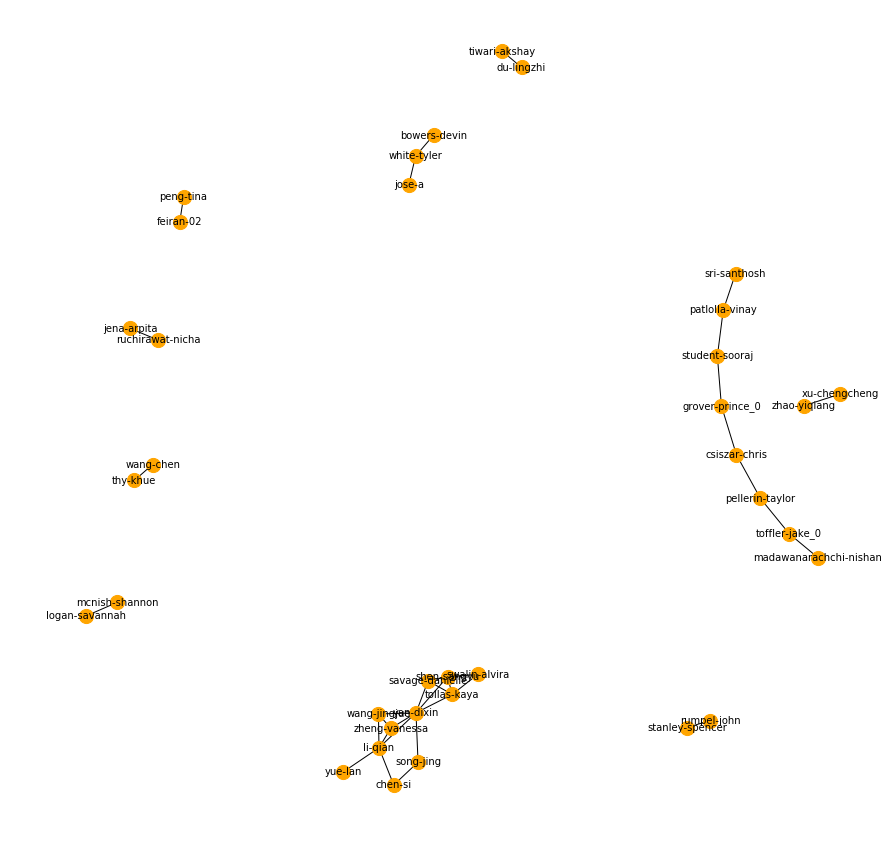

In [621]:
fig, axes = plt.subplots(1, 1, figsize=(15, 15))
nx.draw(G, with_labels=True, node_color='orange', node_size=200, edge_color='black', linewidths=1, font_size=10,ax=axes)